In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandilyasundram","key":"b7679e7751f0b955b09db2c39f3c72a5"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 76% 113M/149M [00:00<00:00, 1.17GB/s]
100% 149M/149M [00:00<00:00, 875MB/s] 


In [ ]:
!unzip brain-tumor-mri-dataset.zip -d brain_tumor_dataset

Streaming output truncated to the last 5000 lines.
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: brain_tumor_

LOADING DATASET

In [ ]:
train_dir ='/content/brain_tumor_dataset/Training'
test_dir ='/content/brain_tumor_dataset/Testing'

In [ ]:
# Loading and shuffling the trainig datasets

train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Loading and shuffling the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

Data Visualization


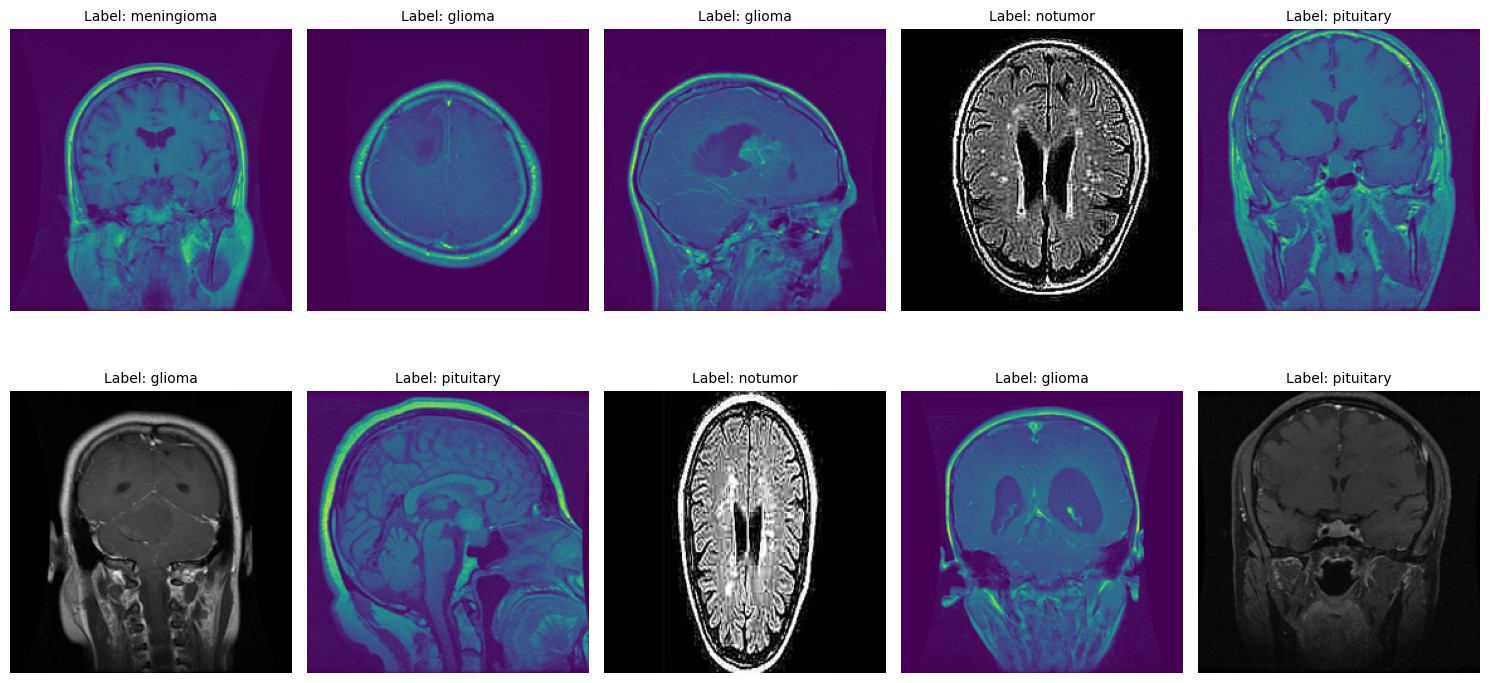

In [ ]:
import matplotlib.pyplot as plt

# Selecting random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Creating a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Loading image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))

    # Displaying image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

Image Preprocessing

In [ ]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

# Loading images and applying augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

Model (VGG16)

In [ ]:
# Model architecture
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Building the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)
epochs = 5

# Training the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1446s 5s/step - loss: 0.6808 - sparse_categorical_accuracy: 0.7229
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1410s 5s/step - loss: 0.2582 - sparse_categorical_accuracy: 0.8996
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1416s 5s/step - loss: 0.1709 - sparse_categorical_accuracy: 0.9337
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1399s 5s/step - loss: 0.1268 - sparse_categorical_accuracy: 0.9512
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 1407s 5s/step - loss: 0.0842 - sparse_categorical_accuracy: 0.9664


Trainig and Validation Plots

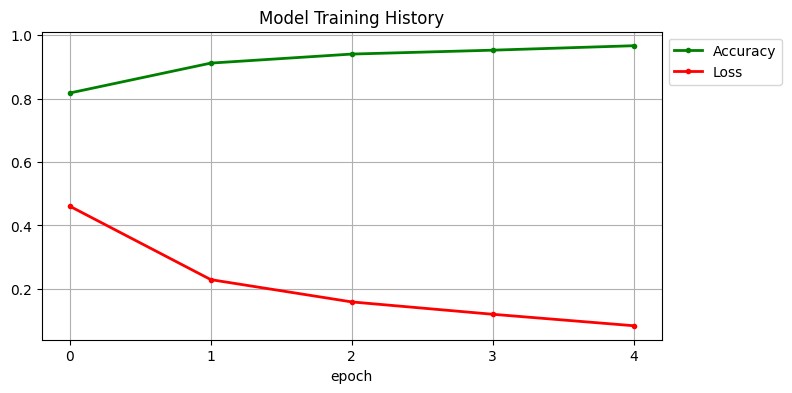

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Model Classification Report

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# Prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

# Predicting using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 269s 7s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       306
           1       0.99      1.00      0.99       405
           2       0.97      0.81      0.88       300
           3       0.90      1.00      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



Confusion Matrix plot

Confusion Matrix:
[[275   4   7  20]
 [  1 403   1   0]
 [ 42   1 244  13]
 [  1   0   0 299]]


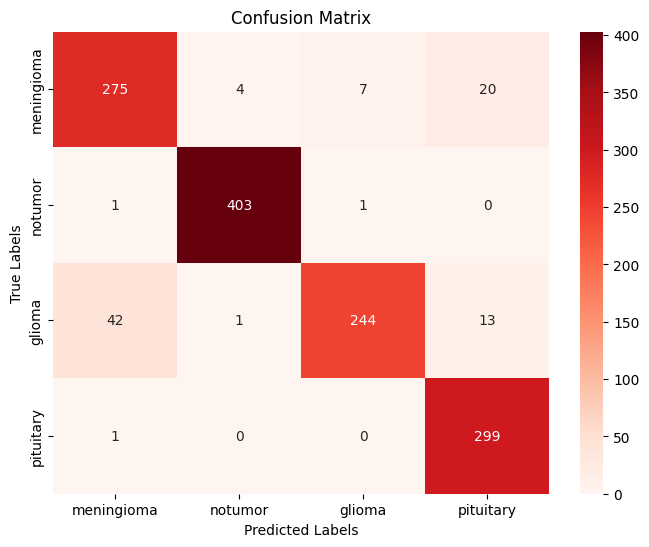

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

ROC Curve

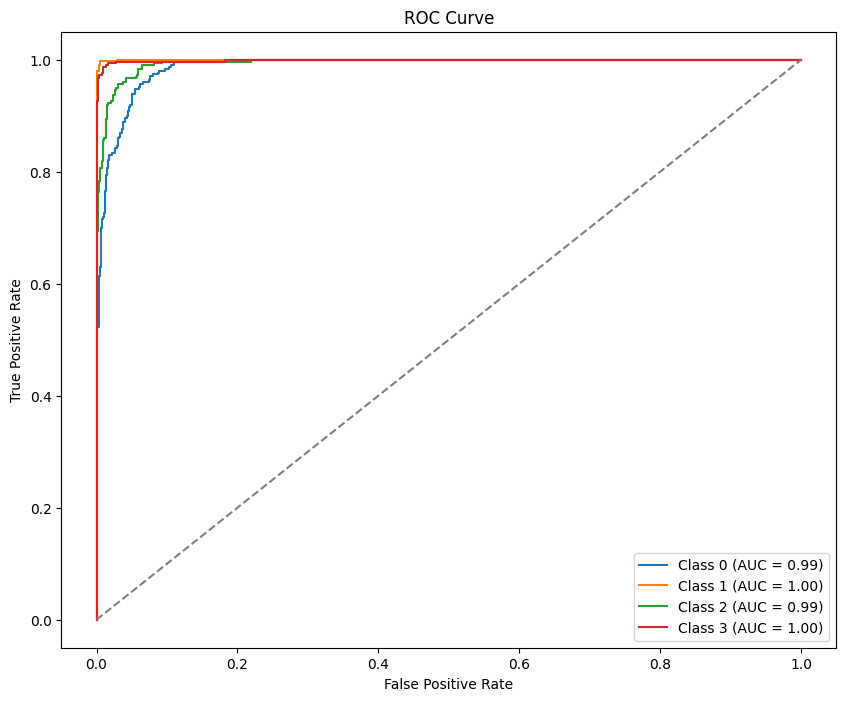

In [ ]:
# Binarizing the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

# Computing ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

Saving and Loading Model

In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')

MRI Tumor Detection System

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Loading and preprocessing the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0) n

        # Making prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determining the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        n
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


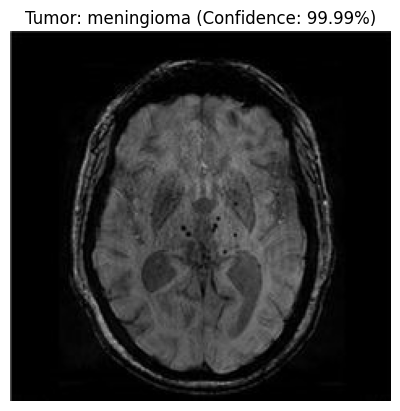

In [ ]:
# Example
image_path = '/content/brain_tumor_dataset/Testing/meningioma/Te-no_0046.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


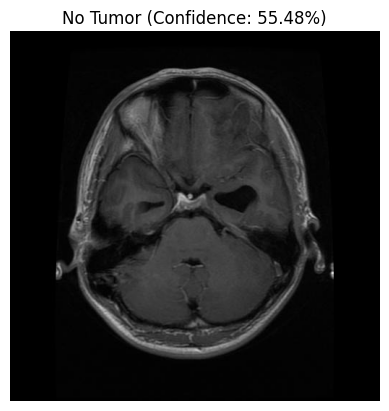

In [ ]:
# Example
image_path = '/content/brain_tumor_dataset/Testing/glioma/Te-glTr_0004.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


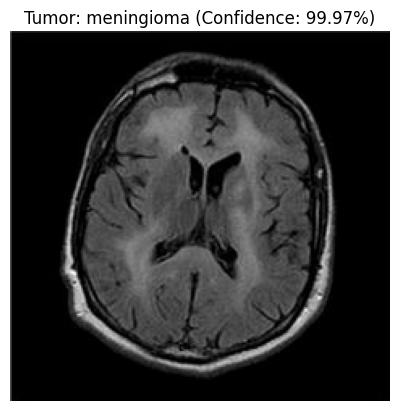

In [ ]:
# Example
image_path = '/content/brain_tumor_dataset/Testing/meningioma/Te-no_0076.jpg'
detect_and_display(image_path, model)